In [12]:
# -----------------------------OpenSG------------------------------
# -------------------3D/Cauchy Continuum Model--------------
#
# This code is developed by Multiscale Structural Mechanics laboratory 
# at Purdue University under the supervision of Prof. Wenbin Yu. This 
# code is intended for general purpose usage for performing accurate
# and precise structural analysis. The code is based on Mechanics of 
# Structure Genome (MSG) theory to perform homogenization and 
# dehomogenization of complex composite laminates like wind blades.
#
# -----------------------------mesh import-------------------------------
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
plt.style.use('classic')
import time

# **Input- .msh file name**
#
fname= "UDcomp_2D"
import subprocess
subprocess.check_output('dolfin-convert  '+ fname+ '.msh  '+ fname +'.xml', shell=True)
mesh = Mesh(fname + ".xml")
subdomains = MeshFunction("size_t", mesh, fname + "_physical_region.xml")

dim=len(mesh.coordinates()[0])
if dim==2:
    # -------------------------------Periodic Boundary Conditions (2DSG)------------------------------- 
    # ** Vertices of the four corners of unit cell**
    vertices = np.array([[-0.5, -0.5], 
                         [0.5, -0.5],   
                         [0.5,0.5],
                         [-0.5,0.5]])

    class PeriodicBoundary(SubDomain):
        def __init__(self, vertices, tolerance=DOLFIN_EPS):
            """ vertices stores the coordinates of the 4 unit cell corners"""
            SubDomain.__init__(self, tolerance)
            self.tol = tolerance
            self.vv = vertices
            self.a1 = self.vv[1,:]-self.vv[0,:] # first vector generating periodicity
            self.a2 = self.vv[3,:]-self.vv[0,:] # second vector generating periodicity
            assert np.linalg.norm(self.vv[2, :]-self.vv[3, :] - self.a1) <= self.tol
            assert np.linalg.norm(self.vv[2, :]-self.vv[1, :] - self.a2) <= self.tol     

        def inside(self, x, on_boundary):
            # return True if on left or bottom boundary AND NOT on one of the 
            # bottom-right or top-left vertices
            return bool((near(x[0], self.vv[0,0] + x[1]*self.a2[0]/self.vv[3,1], self.tol) or 
                         near(x[1], self.vv[0,1] + x[0]*self.a1[1]/self.vv[1,0], self.tol)) and 
                         (not ((near(x[0], self.vv[1,0], self.tol) and near(x[1], self.vv[1,1], self.tol)) or 
                         (near(x[0], self.vv[3,0], self.tol) and near(x[1], self.vv[3,1], self.tol)))) and on_boundary)
        def map(self, x, y):
            if near(x[0], self.vv[2,0], self.tol) and near(x[1], self.vv[2,1], self.tol): # if on top-right corner
                y[0] = x[0] - (self.a1[0]+self.a2[0])
                y[1] = x[1] - (self.a1[1]+self.a2[1])
            elif near(x[0], self.vv[1,0] + x[1]*self.a2[0]/self.vv[2,1], self.tol): # if on right boundary
                y[0] = x[0] - self.a1[0]
                y[1] = x[1] - self.a1[1]
            else:   # should be on top boundary
                y[0] = x[0] - self.a2[0]
                y[1] = x[1] - self.a2[1]
    # -------------------------------Periodic Boundary Conditions End(2D SG)-------------------------------  
elif dim==3:
    # -------------------------------Periodic Boundary Conditions (3D SG)-------------------------------
    vertices = np.array([[0.,0,0],   # 0: Origin
                         [0.5,0,0],   # 1: Right
                         [0,0.5,0],   # 2: Top
                         [0,0,0.5],   # 3: Front
                         [-0.5,0,0],   # 4: left
                         [0,-0.5,0],   # 5: Bottom
                         [0,0,-0.5]])  # 6: Back

    # ** Vertices of the all corners of unit cell**
    class PeriodicBoundary(SubDomain):
        def __init__(self, vertices, tolerance=DOLFIN_EPS):
            SubDomain.__init__(self, tolerance)
            self.tol = tolerance
            self.vv = vertices
            self.a1 = self.vv[1,:]-self.vv[4,:] # first vector generating periodicity
            self.a2 = self.vv[2,:]-self.vv[5,:] # second vector generating periodicity 
            self.a3 = self.vv[3,:]-self.vv[6,:] # third vector generating periodicity       
        def inside(self, x, on_boundary):     

            """return True if on left, bottom, or back faces & 
            not on one of the top, front or right faces or related edges/ vertices)"""

            # faces
            left = near(x[0],self.vv[4,0]) 
            bottom = near(x[1],self.vv[5,1]) 
            back = near(x[2],self.vv[6,2])
            right = near(x[0],self.vv[1,0])
            top = near(x[1],self.vv[2,1])
            front = near(x[2],self.vv[3,2])

            # line-segments (bottom 4; top 4; vertical 4) edges
            bottom_front = bottom and front 
            bottom_right = bottom and right 

            top_left = top and left 
            top_back = top and back 

            left_front = left and front 
            right_back = right and back 

            return bool((left or back or bottom) and 
                        (not( (top_left) or (left_front) or (top_back) or (right_back) or (bottom_right) or (bottom_front))) and on_boundary)

        def map(self, x, y):
            """ Mapping the right boundary to left, front to back and top to bottom"""

            # faces
            right = near(x[0],self.vv[1,0])
            top = near(x[1],self.vv[2,1])
            front = near(x[2],self.vv[3,2])

            # line-segments 
            top_right = top and right 
            top_front = top and front 
            right_front = right and front 
            point_6 = right and front and top 

            if point_6:
                y[0] = x[0] - (self.a1[0] + self.a2[0] + self.a3[0])
                y[1] = x[1] - (self.a1[1] + self.a2[1] + self.a3[1])
                y[2] = x[2] - (self.a1[2] + self.a2[2] + self.a3[2])
            elif top_right:
                y[0] = x[0] - (self.a1[0] + self.a2[0])
                y[1] = x[1] - (self.a1[1] + self.a2[1])
                y[2] = x[2] - (self.a1[2] + self.a2[2])
            elif top_front:
                y[0] = x[0] - (self.a2[0] + self.a3[0])
                y[1] = x[1] - (self.a2[1] + self.a3[1])
                y[2] = x[2] - (self.a2[2] + self.a3[2])
            elif right_front: 
                y[0] = x[0] - (self.a1[0] + self.a3[0])
                y[1] = x[1] - (self.a1[1] + self.a3[1])
                y[2] = x[2] - (self.a1[2] + self.a3[2])
            elif right:
                y[0] = x[0] - (self.a1[0])
                y[1] = x[1] - (self.a1[1])
                y[2] = x[2] - (self.a1[2])
            elif front:
                y[0] = x[0] - (self.a3[0])
                y[1] = x[1] - (self.a3[1])
                y[2] = x[2] - (self.a3[2])
            elif top:
                y[0] = x[0] - (self.a2[0])
                y[1] = x[1] - (self.a2[1])
                y[2] = x[2] - (self.a2[2])
            else: 
                y[0] = -1. 
                y[1] = -1. 
                y[2] = -1. 
    #-------------------Periodic Boundary Conditions (3DSG) End---------------
#
#----------------------------- Material Data Input-----------------------------

# **The sequence of material initialization is corresponding to subdomain (physical_region) sequence**
# Matrix
E, v=4.76e3, 0.37
G=E/2/(1+v)
material_parameters=[(E,E,E,G,G,G,v,v,v)]

# Fiber
E1,E2,E3= 276e3, 19.5e3, 19.5e3
G12,G13,G23= 70e3, 70e3, 5.735e3
v12,v13,v23 = 0.28, 0.28, 0.70
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))
 
nphases = len(material_parameters)

# -----------------------------Functions-----------------------------
start = time.time()

# ---------------------MSG Theory Implement------------------------

def eps(v):
    if dim==2:
        E1=as_vector([0,v[1].dx(0),v[2].dx(1),v[1].dx(1)+v[2].dx(0),v[0].dx(1),v[0].dx(0)]) 
    elif dim==3:
        E1=as_vector([v[0].dx(0),v[1].dx(1),v[2].dx(2),(v[1].dx(2)+v[2].dx(1)),(v[0].dx(2)+v[2].dx(0)),(v[0].dx(1)+v[1].dx(0))])  
    return as_tensor([(E1[0],0.5*E1[5],0.5*E1[4]),(0.5*E1[5],E1[1],0.5*E1[3]),(0.5*E1[4],0.5*E1[3],E1[2])]),E1

def sigma(v,i,Eps):
        E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
        S=np.zeros((6,6))
        S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E2
        S[0,1], S[0,2]= -v12/E1, -v13/E1
        S[1,0], S[1,2]= -v12/E1, -v23/E2
        S[2,0], S[2,1]= -v13/E1, -v23/E2
        S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
        C=as_tensor(np.linalg.inv(S))
        s1= dot(C,eps(v)[1]+Eps)
        return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])]),C

#-----------------Finite Element function Space-------------------------------------------

Ve = VectorElement("CG", mesh.ufl_cell(), 1,dim=3) # 1: order of shape functions
Re = VectorElement("R", mesh.ufl_cell(), 0,dim=3)
W = FunctionSpace(mesh, MixedElement([Ve,Re]), constrained_domain=PeriodicBoundary(vertices, tolerance=1e-10))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
Eps= as_vector((1,0,0,0,0,0))
dx = Measure('dx')(domain=mesh, subdomain_data=subdomains)
F = sum([inner(sigma(dv, i, Eps)[0], eps(v_)[0])*dx(i) for i in range(nphases)])

a=lhs(F)+ dot(lamb_,dv)*dx + dot(dlamb,v_)*dx
x=len(assemble(rhs(F)).get_local())   

# Omega (SG Volume)
omega=assemble(sum([Constant(1)*dx(i)for i in range(nphases)]))
# -----------------------------------Assembly-----------------------------------
V0 = np.zeros((x,6))
Dhe = np.zeros((x,6))
D_bar=np.zeros((6,6))
for p in range(6):
        a1=np.zeros((6,))
        a1[p]=1
        Eps=as_vector((a1[0],a1[1],a1[2],a1[3],a1[4],a1[5]))
        F = sum([inner(sigma(dv, i, Eps)[0], eps(v_)[0])*dx(i) for i in range(nphases)])           
        L = rhs(F)      
        w = Function(W)
        solve(a == L, w,[])
        V0[:,p]= w.vector().get_local() # V0 matrix formation
        Dhe[:,p]= assemble(L).get_local() # Dhe matrix formation
        
D1=np.matmul(V0.T,-Dhe)
for s in range(6):
    for k in range(6):
        D_bar[s,k]=assemble(sum([(sigma(dv, i, Eps)[1][s,k])*dx(i) for i in range(nphases)]))
D_eff= D_bar+D1 # Effective Stiffness Matrix 
D_eff= D_eff/omega
#-------------------------Printing Output Data-------------------------------

Com=np.linalg.inv(D_eff)  
E1,E2,E3=1/Com[0,0], 1/Com[1,1], 1/Com[2,2]
v12,v13,v23=-Com[0,1]/Com[0,0], -Com[0,2]/Com[0,0], -Com[1,2]/Com[1,1]
G23,G13,G12=1/Com[3,3], 1/Com[4,4], 1/Com[5,5]

end = time.time()
print(E1)
print('time taken', end - start)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
167255.33746251345
time taken 0.35045289993286133


Solving linear variational problem.
Solving linear variational problem.
1


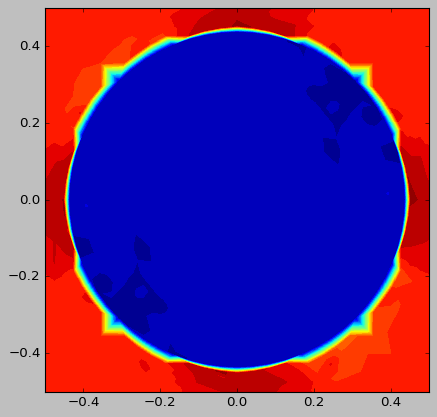

Solving linear variational problem.
Solving linear variational problem.
2


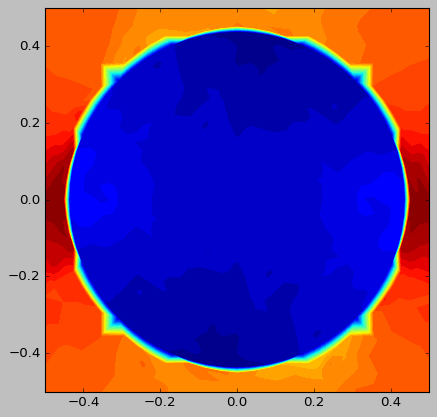

Solving linear variational problem.
Solving linear variational problem.
3


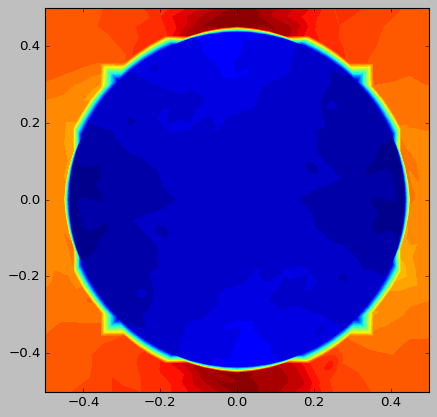

Solving linear variational problem.
Solving linear variational problem.
4


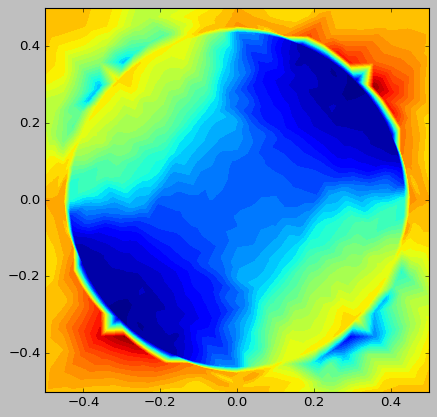

Solving linear variational problem.
Solving linear variational problem.
5


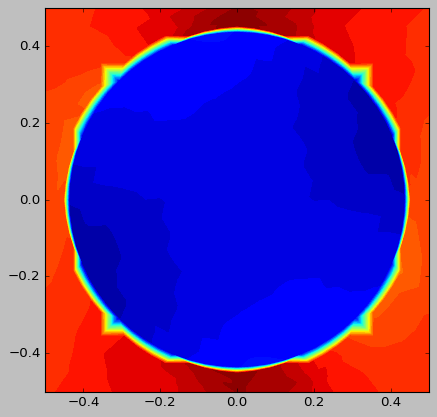

Solving linear variational problem.
Solving linear variational problem.
6


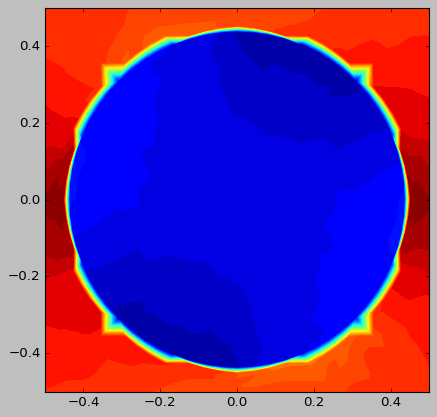

In [13]:
## -----------------------------Dehomogenization-----------------------------
## DEHOMOGENIZATION

# Input Global Strain
st=np.array(([0.01,0.01,0.01,0.01,0.01,0.01]))

# Using Warping Functions
a1=np.matmul(V0,st)
w_1=Function(W)
for i in range(x):
    w_1.vector()[i]=a1[i]
    
# 3D strain recovery
st_3D=eps(w_1)[1]

def sigma_vec(st_3D,i):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,st_3D)
    return s1

V = FunctionSpace(mesh, 'DG', 1)

for pp in range(6):    

    # Create functions in parts
    VV0 = FunctionSpace(mesh, 'DG', 1)
    u0 = project(sigma_vec(st_3D,0)[pp], VV0)

    V1 = FunctionSpace(mesh, 'DG', 1)
    u1 = project(sigma_vec(st_3D,1)[pp], V1)

    # Begin glueing
    uu = TrialFunction(V)
    vv = TestFunction(V)
    aa = inner(uu, vv)*dx

    # Function v0 is u0 in mesh0 and 0 otherwise
    L0 = inner(u0, vv)*dx(0, subdomain_data=subdomains)
    v0 = Function(V)
    solve(aa == L0, v0)

    # Function v1 is u1 in mesh1 and 0 otherwise
    L1 = inner(u1, vv)*dx(1, subdomain_data=subdomains)
    v1 = Function(V)
    solve(aa == L1, v1)

    # Combine
    vvv = Function(V, v0.vector())
    vvv.vector()[:] += v1.vector()

    # Getting stress at origin (x,y,z)
    plot(vvv)
    print(pp+1)
    plt.show()